In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [2]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [3]:
import sys
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import  lines
from matplotlib import rc, rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Polygon, Ellipse
import numpy as np
from math import *
from time import time
import wl_to_rgb as col
import random
from astropy.io import ascii
from astropy.table import Table, Column 
import pyfits
import pylab as py
from astropy import coordinates as coord
from astropy import units as unit
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as mpatches

from matplotlib import *

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [4]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [5]:
col_pallet = ['darkviolet', 'blue', 'deepskyblue', 'forestgreen', 'y', 'gold', 'darkorange', 'red', 'magenta', 'maroon', 'sienna', 'slategrey', 'black']
vel_pallet = [-100000, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12000, 15000, 20000]
def color_table(Velocity):
    colours = []
    for j, v in enumerate(Velocity):
        col = "white"
        for i in range(len(vel_pallet)-1):
            if vel_pallet[i] <= v and v < vel_pallet[i+1]:
                col = col_pallet[i]
                break
        colours.append(col)
    return colours

In [6]:
def xymap_aitoff(x, y):
  
    while x > 360:
        x-=360
    while x < 0:
        x+=360

    x0 = (180.-x)*pi/180.
    y0 = y*pi/180.
  
    return x0, y0
################################################################ 

def esn_aitoff_patch(ax, x0, y0, d, color='blue'):

    vertices = []
    x, y = xymap_aitoff(x0,y0) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0) 
    vertices.append([x,y]) 
    ax.add_patch(Polygon(vertices, closed=True, fill=True, color=color))

In [7]:
def get_TFR():
    
    df = pd.read_csv('df_TFR.csv', delimiter=',')
    df["PGC1"] = df.pgc1
    df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
    df = df.set_index('PGC')

    print(len(df))

    catalogs = ["cf4", "spitzer", "cf2", "sfi", "2mtf", "flat"]
    ind = (df["Vcmb_cf4"].isna()) | (df["Vcmb_cf4"]==0)
    print(len(df["Vcmb_cf4"][ind]))

    for cat in catalogs:
        ind = (df["Vcmb_cf4"].isna()) | (df["Vcmb_cf4"]==0)
        df["Vcmb_cf4"][ind] = df["Vcmb_"+cat][ind]

    ind = (df["Vcmb_cf4"].isna()) | (df["Vcmb_cf4"]==0)
    df["Vcmb_cf4"][ind] = np.nan

    df = df.rename(columns={'Vcmb_cf4': 'Vcmb',
                           })

    leda = pd.read_csv('Leda_bar.csv', delimiter='|')
    leda = leda.set_index('PGC')

    df = df.join(leda, lsuffix='_cf4', rsuffix='_leda', how='inner')
    df = df[["PGC1", "Vcmb", "sgl", "sgb"]]

    dg = df.groupby('PGC1').agg(["mean", "count"])

    df["Vgrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['mean'])
    df["Ngrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['count'])

    df = df.sort_values(by=['Vgrp', 'PGC1'])
    df = df[df["Vgrp"]<15000]
    
    return df

In [8]:
def get_FP():
    
    df = pd.read_csv('FP_CF4_components_bar.csv', delimiter='|')
    df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
    df = df.set_index('PGC')

    leda = pd.read_csv('Leda_bar.csv', delimiter='|')
    leda = leda.set_index('PGC')

    df = df.join(leda, lsuffix='_6dfgs', rsuffix='_leda', how="inner")
    df = df[["PGC1", "Vcmb", "sgl", "sgb"]]
    df = df.astype({"PGC1": int})

    dg = df.groupby('PGC1').agg(["mean", "count"])

    df["Vgrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['mean'])
    df["Ngrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['count'])

    df = df.sort_values(by=['Vgrp', 'PGC1'], ascending=False)

    vel = df.Vcmb.values
    vel = df.Vgrp.values

    df = df[df["Vgrp"]<15000]

    vel = df.Vcmb.values
    vel = df.Vgrp.values
    
    return df

In [9]:
def get_sni():
    leda = pd.read_csv('Leda_bar.csv', delimiter='|')
    leda = leda.set_index('PGC')

    df = pd.read_csv('./all_cf4_sni1_sample.csv', delimiter='|')
    df = df.rename(columns=lambda x: x.strip())
    df = df.set_index('PGC')
    df = df.drop(columns=['1PGC'])

    catalogs = []
    catalogs = ["sh0es"]
    catalogs += ["pantheonplus"]
    catalogs += ["scolnic"]
    catalogs += ["csp1"]
    catalogs += ["ganesh"]
    catalogs += ["rest"]
    catalogs += ["amanullah"]
    catalogs += ["jha"]
    catalogs += ["prieto"]
    catalogs += ["hicken"]
    catalogs += ["folatelli"]
    catalogs += ["walker"]
    catalogs += ["stahl"]
    catalogs += ["twins"]
    catalogs += ["avelino"]

    for cat in catalogs:
        df["eDM_"+cat][df["DM_"+cat]==0] = np.nan
        df["DM_"+cat][df["DM_"+cat]==0] = np.nan
        df['PGC1_'+cat] = df.index
        df['PGC1_'+cat][df["DM_"+cat].isna()] = np.nan
        df['Vcmb_'+cat] = df["Vcmb"]
        df['Vcmb_'+cat][df["DM_"+cat].isna()] = np.nan
    
    df["Vgrp"] = df["Vcmb"]
    
    df = df[df["Vgrp"]<15000]

    return df

In [10]:
def get_snii():
    
    df = pd.read_csv('de_jaeget_snii.csv', delimiter='|')
    df = df.rename(columns=lambda x: x.strip())

    df = df.set_index('PGC')
    df["Vgrp"] = df["Vcmb"]
    df = df[df["Vgrp"]<15000]
    
    df = df.rename(columns={"SGL":"sgl", "SGB":"sgb"})
    
    return df

In [11]:
def get_sbf():
    
    df = pd.read_csv("All_CF4_4aitoff.csv")
    df = df[df["Vgrp"]<15000]
    
    return df

In [12]:
def plot_catalog(ax, df):
    
    sgl_gal = df.sgl.values
    sgb_gal = df.sgb.values
    N = len(sgl_gal)
    X = np.zeros(N)
    Y = np.zeros(N)
    for i in range(N):
        X[i], Y[i] = xymap_aitoff(sgl_gal[i], sgb_gal[i])

    colours = color_table(df.Vgrp.values)

    for i, c in enumerate(colours):
        ax.plot([X[i]], [Y[i]], color=c, marker='.', ms=2)

In [13]:
df_tfr = get_TFR()
df_fp  = get_FP()
df_sni = get_sni()

df_snii = get_snii()
df_sbf  = get_sbf()

12412
2950


/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

CPU times: user 51min 37s, sys: 8.67 s, total: 51min 46s
Wall time: 51min 43s


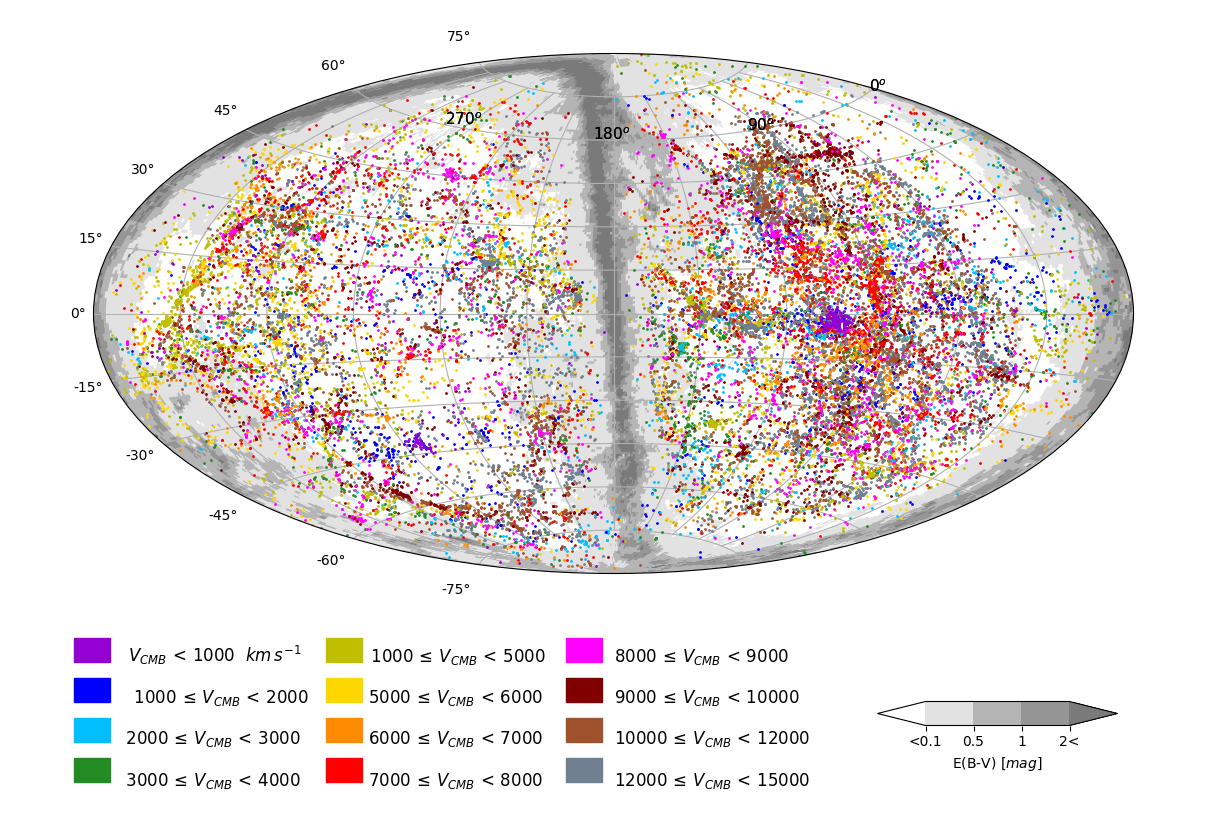

In [14]:
%%time 

l0 = 180
deg = 0.8
a = pyfits.open('EBV.0.8.deg.fits')
d = a[1].data

SGL  = d['SGL']
SGB  = d['SGB']
EBV = d['EBV']

fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection="aitoff")
# plt.title("Supergalactic Aitoff Projection (TF samples)", y=1.08)
ax.grid(True)
ax.set_xticklabels([])
plt.subplots_adjust(top=0.95, bottom=0.3, right=0.95, left=0.05)

ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')

ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')  
################################################################ 
################################################################ 

jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(len(SGB)):
    if EBV[i]>2.0: val = 3
    elif EBV[i]>1.0: val = 2.5
    elif EBV[i]>0.5: val= 2.0
    elif EBV[i]<=0.5 and EBV[i]>0.1: val= 1.0
    elif EBV[i]<0.1: val= 0
    else: val= 0
    colorVal = scalarMap.to_rgba(val)
    esn_aitoff_patch(ax, SGL[i], SGB[i], deg, color=colorVal)


############################################

ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
ax2.set_axis_off()
ax2.set_xticks([])
ax2.set_yticks([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.annotate(r"$\/\/ V_{CMB} \/ < \/ 1000 \/\/\/\/ km\/ s^{-1}  $", (0.1,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$ \/\/\/\/ 1000 \/ \leq \/ V_{CMB} \/ < \/ 2000$', (0.1,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 2000 \/ \leq \/ V_{CMB} \/ < \/ 3000$', (0.1,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 3000 \/ \leq \/ V_{CMB} \/ < \/ 4000$', (0.1,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 1000 \/ \leq \/ V_{CMB} \/ < \/ 5000$', (0.30,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$5000 \/ \leq \/ V_{CMB} \/ < \/ 6000$', (0.30,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$6000 \/ \leq \/ V_{CMB} \/ < \/ 7000$', (0.30,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$7000 \/ \leq \/ V_{CMB} \/ < \/ 8000$', (0.30,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$8000 \/ \leq \/ V_{CMB} \/ < \/ 9000$', (0.5,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$9000 \/ \leq \/ V_{CMB} \/ < \/ 10000$', (0.5,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$10000 \/ \leq \/ V_{CMB} \/ < \/ 12000$', (0.5,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$12000 \/ \leq \/ V_{CMB} \/ < \/ 15000$', (0.5,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
# ax2.annotate(r'$15000 \/ \leq \/ V_{CMB}$', (0.7,0.2), xycoords='figure fraction', size=12, color='black')

p = 0
for m in [0.1,0.31,0.51]:
    for n in [0.19,0.19-0.05,0.19-2*0.05,0.19-3*0.05]:
        ax2.add_patch(patches.Rectangle((m-0.05, n), 0.03, 0.03, color=col_pallet[p]))
        p+=1
# ax2.add_patch(patches.Rectangle((0.71-0.05, 0.19), 0.03, 0.03, color=col_pallet[p]))


################################################################ 
jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
ax3 = fig.add_axes([0.720, 0.11, 0.2, 0.03])
cols = []
bounds = [0,1,2,3]

cols.append(scalarMap.to_rgba(1.0))
cols.append(scalarMap.to_rgba(2.0))
cols.append(scalarMap.to_rgba(2.5))




cm = colors.ListedColormap(cols)

cm.set_over(scalarMap.to_rgba(3.0))
cm.set_under(scalarMap.to_rgba(0))

cNorm  = colors.BoundaryNorm(bounds, cm.N)
cbar = colorbar.ColorbarBase(ax3, cmap=cm, norm=cNorm, orientation='horizontal',ticks=bounds, boundaries=[-1]+bounds+[4],extend='both',extendfrac='auto')
cbar.set_ticks(bounds)
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_xticklabels(['<0.1','0.5','1','2<'])  # horizontal colorbar

cbar.set_label('E(B-V) '+r'$[mag]$')
################################################################   


plot_catalog(ax, df_tfr)
plot_catalog(ax, df_fp)
plot_catalog(ax, df_sni)
plot_catalog(ax, df_snii)
plot_catalog(ax, df_sbf)